# Deep learning

Playing around with deep learning using TensorFlow

Try to train a model to differentiate between circles and squares


## Data

I made 30 images of circles and 30 images of squares in Inkscape, which I saved as `.svg` files.  It was too much bother to use `cairo` to load these files, so I used `imagemagick` to convert them to `.png`.

The first step is to load these files

In [1]:
import glob
import os
import re

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

One image looks like this:

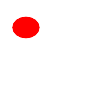

In [2]:
# load one image
file = "shapes/circle1.png"
img = Image.open(file)
img

I convert the images to greyscale:

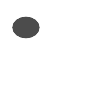

In [3]:
# convert to greyscale
img = ImageOps.grayscale(img)
img

I also resduce their size to 25x25 pixels

In [4]:
img.thumbnail((25,25), Image.ANTIALIAS)
img

And then to a numpy array, and scale all the values to be between 0 and 1:

In [5]:
# convert to numpy array
print(np.array(img).astype(np.float32) / 255)
print(np.array(img).shape) 

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.        ]
 [1.         1.         1.         1.         0.99215686 0.99607843
  1.         0.99607843 0.99215686 1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.        ]
 [1.         1.         1.         0.99607843 1.         1.
  0.99607843 1.         1.         0.99607843 1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.  

In [6]:
# function to load data
def load_img(filename):
    img = Image.open(filename)
    img = ImageOps.grayscale(img)
    img.thumbnail((25,25), Image.ANTIALIAS)
    return np.array(img).astype(np.float32) / 255


# load data in dataframe
df = pd.DataFrame({'filename' : glob.glob("shapes/*png")})

df['num'] = df['filename'].map(lambda x: int(re.search("\\d+", x).group(0)))

df['shape'] = df['filename'].map(lambda x: 'circle' if 'circle' in x else 'square')

df['pixels'] = df['filename'].map(load_img)

df['label'] = df['shape'].map(lambda x: 1 if x=='circle' else 0)


In [7]:
# randomize rows
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filename,num,shape,pixels,label
0,shapes/square43.png,43,square,"[[1.0, 0.99215686, 0.5411765, 0.45882353, 0.46...",0
1,shapes/square34.png,34,square,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
2,shapes/square32.png,32,square,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
3,shapes/circle13.png,13,circle,"[[1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0....",1
4,shapes/circle11.png,11,circle,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1


Let's look at a few of the images:

In [8]:
img = Image.fromarray(df['pixels'][0])
print(df['shape'][0])
display(ImageOps.grayscale(img))


square


In [9]:

img2 = Image.fromarray(df['pixels'][1])
print(df['shape'][1])
display(ImageOps.grayscale(img2))

square


They look the same?!  Let's compare the arrays:

In [10]:
df['pixels'][0] == df['pixels'][1]

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True,  True],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False,  True,  True],
       [False, False, False, False, False,  True, False,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False, False,  True, False,  True,  True],


Something strange is going on...  Let's try displaying them with matplotlib:

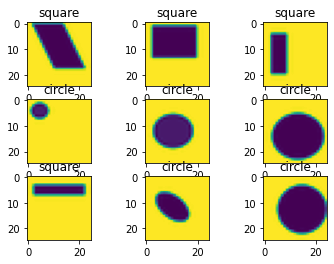

In [67]:
fig, axs = plt.subplots(3,3)
k = 0
for i in range(3):
    for j in range(3):
        
        axs[i,j].imshow(df['pixels'][k])
        axs[i,j].set_title(df['shape'][k])
        k += 1

So it's just something weird going on with PIL.

Let's split the data into a test and train dataset - 80% for testing, 20% for training

In [13]:
test_rows = round(df.shape[0] * 0.8)
x_train, x_test = df['pixels'][1:test_rows].to_list(), df['pixels'][test_rows:].to_list()
y_train, y_test = df['label'][1:test_rows], df['label'][test_rows:]

In [14]:
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
t_test = tf.convert_to_tensor(y_train)

2022-02-24 11:59:26.405428: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model

We next define the model - I use something similar to the [basic example in the documentation](https://www.tensorflow.org/tutorials/keras/classification).  THe first layer reformats the 100x100 images, the second contains 128 nodes, and the last returns a logits array with length 2 (the number of classes)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(25, 25)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(x_train, y_train, epochs=10)



Epoch 1/10
3/3 [==============================] - 0s 3ms/step - loss: 1.2372 - accuracy: 0.4574
Epoch 2/10
3/3 [==============================] - 0s 2ms/step - loss: 0.9806 - accuracy: 0.4894
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5638
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 0.8119 - accuracy: 0.5426
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 0.7485 - accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 0.7052 - accuracy: 0.5319
Epoch 7/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.5957
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.5957
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.5745
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.6277


The model has learned something, but can it be improved?  Perhaps we could try the [keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [17]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(25, 25)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(2))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [18]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                    overwrite=True)


In [19]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 00m 00s]
val_accuracy: 0.7368420958518982

Best val_accuracy So Far: 0.8421052694320679
Total elapsed time: 00h 00m 21s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
3/3 [==============================] - 0s 60ms/step - loss: 2.3643 - accuracy: 0.4267 - val_loss: 1.5244 - val_accuracy: 0.3158
Epoch 2/50
3/3 [==============================] - 0s 11ms/step - loss: 1.2288 - accuracy: 0.4267 - val_loss: 0.6118 - val_accuracy: 0.6842
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9069 - accuracy: 0.4133 - val_loss: 1.6678 - val_accuracy: 0.3158
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9658 - accuracy: 0.5733 - val_loss: 0.8801 - val_accuracy: 0.3684
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.7456 - accuracy: 0.5067 - val_loss: 0.5954 - val_accuracy: 0.7368
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.7978 - accuracy: 0.5200 - val_loss: 0.9086 - val_accuracy: 0.3684
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6954 - accuracy: 0.6000 - val_loss: 0.8963 - val_accuracy: 0.3684
Epoch 8/50
3/3 [===========

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)


1/1 [==============================] - 0s 99ms/step - loss: 1.1367 - accuracy: 0.4583

Test accuracy: 0.4583333432674408


In [22]:
# reinstantitate the hypermodel and train with the optimal number of epochs above
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)


Epoch 1/20
3/3 [==============================] - 0s 63ms/step - loss: 2.0866 - accuracy: 0.4533 - val_loss: 1.8597 - val_accuracy: 0.3158
Epoch 2/20
3/3 [==============================] - 0s 12ms/step - loss: 1.6694 - accuracy: 0.5733 - val_loss: 2.5933 - val_accuracy: 0.3158
Epoch 3/20
3/3 [==============================] - 0s 11ms/step - loss: 1.1739 - accuracy: 0.5867 - val_loss: 0.5976 - val_accuracy: 0.6842
Epoch 4/20
3/3 [==============================] - 0s 12ms/step - loss: 1.2589 - accuracy: 0.4400 - val_loss: 0.6257 - val_accuracy: 0.6842
Epoch 5/20
3/3 [==============================] - 0s 11ms/step - loss: 0.8220 - accuracy: 0.5200 - val_loss: 1.2765 - val_accuracy: 0.3158
Epoch 6/20
3/3 [==============================] - 0s 12ms/step - loss: 1.0010 - accuracy: 0.5733 - val_loss: 1.7504 - val_accuracy: 0.3158
Epoch 7/20
3/3 [==============================] - 0s 12ms/step - loss: 0.9881 - accuracy: 0.5733 - val_loss: 0.7848 - val_accuracy: 0.4211
Epoch 8/20
3/3 [===========

In [23]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)


1/1 [==============================] - 0s 93ms/step - loss: 0.7542 - accuracy: 0.5000
[test loss, test accuracy]: [0.7541597485542297, 0.5]


So the final accuracy is around 75%.  Can we do better?

## Trimming images
Perhaps we should try trimming the whitespace in the images?  



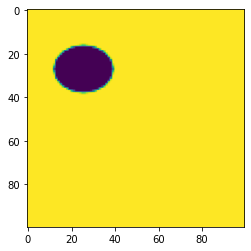

In [46]:
img_test = Image.open(file)
img_test = ImageOps.grayscale(img_test)
img_test = np.array(img_test).astype(np.float32)

plt.imshow(img_test)

In [47]:

def trim_whitespace(img_np):
    
    # trim down from top
    first_row = 0
    while first_row < img_np.shape[0]:
        if (img_np[first_row, :] == 255).all():
            first_row += 1
        else:
            break
    
    # trim up from bottom
    last_row = img_np.shape[0] - 1
    while last_row >= 0:
        if (img_np[last_row, :] == 255).all():
            last_row -= 1
        else:
            break
            
    # trim in from left
    first_col = 0
    while first_col < img_np.shape[1]:
        if (img_np[:,first_col] == 255).all():
            first_col += 1
        else:
            break
            
    # trim in from right
    last_col = img_np.shape[1] - 1
    while last_col > 0:
        if (img_np[:,last_col] == 255).all():
            last_col -= 1
        else:
            break
            
            
    return img_np[first_row:last_row, first_col:last_col]
                  
trimmed = trim_whitespace(img_test)
print(trimmed)

[[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 250. 235. 213.
  216. 237. 251. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 251. 186. 125.  76.  76.  76.  76.
   76.  76.  76.  78. 130. 197. 254. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 253. 196.  76.  76.  76.  76.  76.  76.  76.
   76.  76.  76.  76.  76.  76.  79. 206. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 205.  78.  76.  76.  76.  76.  76.  76.  76.  76.
   76.  76.  76.  76.  76.  76.  76.  76.  96. 214. 255. 255. 255.]
 [255. 255. 255. 203.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.
   76.  76.  76.  76.  76.  76.  76.  76.  76.  76. 218. 255. 255.]
 [255. 255. 223.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.
   76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76. 235. 255.]
 [255. 238.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.
   76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  76.  80. 246.]
 [255. 105.  76.  76

After trimming, the image looks like this:

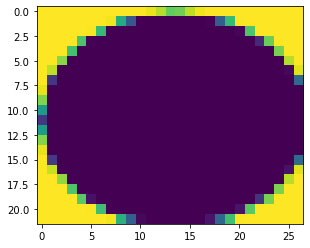

In [48]:
trimmed_img = Image.fromarray(trimmed)
plt.imshow(trimmed)

After trimming, I scale the images back to 25x25 pixels

In [49]:
trimmed_img = trimmed_img.resize((25,25), Image.ANTIALIAS)
ImageOps.grayscale(trimmed_img)


In [50]:
def load_img_crop_resize(filename):
    # load image with PIL
    img = Image.open(filename)
    img = ImageOps.grayscale(img)
    
    # convert to numpy array and trim whitespace
    img_np = np.array(img).astype(np.float32)
    img_np = trim_whitespace(img_np)
    
    # convert back to PIL Image to rescale back to 25x25 pixels
    img = Image.fromarray(img_np)
    img = img.resize((25,25), Image.ANTIALIAS)
    img = ImageOps.grayscale(img)
    
    # return image array scaled to values between 0 and 1
    return np.array(img).astype(np.float32) / 255

df['resized_shape'] = df['filename'].map(load_img_crop_resize)

In [51]:
df.head()

,filename,num,shape,pixels,label,resized_shape
0,shapes/square43.png,43,square,"[[1.0, 0.99215686, 0.5411765, 0.45882353, 0.46...",0,"[[0.37254903, 0.27058825, 0.2901961, 0.2862745..."
1,shapes/square34.png,34,square,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0,"[[0.17254902, 0.105882354, 0.11764706, 0.11372..."
2,shapes/square32.png,32,square,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0,"[[0.43137255, 0.007843138, 0.007843138, 0.0078..."
3,shapes/circle13.png,13,circle,"[[1.0, 1.0, 0.99607843, 1.0, 1.0, 1.0, 1.0, 0....",1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,shapes/circle11.png,11,circle,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,"[[1.0, 1.0, 0.99607843, 1.0, 0.99607843, 0.988..."


Let's check some of the images to make sure they're right:

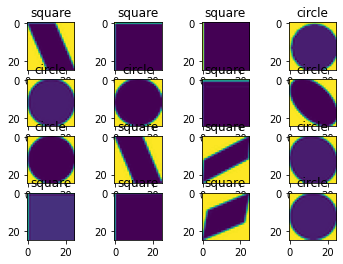

In [69]:
n_side = 4
fig, axs = plt.subplots(n_side,n_side)
k = 0
for i in range(n_side):
    for j in range(n_side):
        
        axs[i,j].imshow(df['resized_shape'][k])
        axs[i,j].set_title(df['shape'][k])
        k += 1

Let's try training the model again

In [72]:
test_rows = round(df.shape[0] * 0.8)
x_train, x_test = df['resized_shape'][1:test_rows].to_list(), df['resized_shape'][test_rows:].to_list()
y_train, y_test = df['label'][1:test_rows], df['label'][test_rows:]

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
t_test = tf.convert_to_tensor(y_train)

In [73]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(25, 25)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
model2.fit(x_train, y_train, epochs=10)

Epoch 1/10
3/3 [==============================] - 0s 2ms/step - loss: 0.6399 - accuracy: 0.6277
Epoch 2/10
3/3 [==============================] - 0s 2ms/step - loss: 0.4060 - accuracy: 0.8723
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 0.3479 - accuracy: 0.8511
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.9149
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.9468
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 0.2462 - accuracy: 0.9362
Epoch 7/10
3/3 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9468
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9468
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9681
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9681


It seems to do much better now - 96% accuracy.  Let's check the test set.

In [75]:
eval_result = model2.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 88ms/step - loss: 0.3619 - accuracy: 0.8333
[test loss, test accuracy]: [0.361851304769516, 0.8333333134651184]


It seems to have overfit a bit - the accuracy of the test set is lower than the training set.  Pehaps the hyperparamter tuning can help us with this?

In [76]:
tuner2 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_2',
                    overwrite=True)


In [77]:
tuner2.search(x_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 00m 00s]
val_accuracy: 0.9473684430122375

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 21s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model2 = tuner2.hypermodel.build(best_hps)
history = model2.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [80]:
# reinstantitate the hypermodel and train with the optimal number of epochs above
hypermodel2 = tuner2.hypermodel.build(best_hps)

# Retrain the model
hypermodel2.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/3
3/3 [==============================] - 0s 59ms/step - loss: 0.5733 - accuracy: 0.6667 - val_loss: 0.4943 - val_accuracy: 0.7895
Epoch 2/3
3/3 [==============================] - 0s 11ms/step - loss: 0.4959 - accuracy: 0.6800 - val_loss: 0.4223 - val_accuracy: 0.6842
Epoch 3/3
3/3 [==============================] - 0s 12ms/step - loss: 0.3379 - accuracy: 0.7200 - val_loss: 0.4833 - val_accuracy: 0.5789


In [81]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)


1/1 [==============================] - 0s 18ms/step - loss: 0.4863 - accuracy: 0.9167

Test accuracy: 0.9166666865348816


The final accuracy on the test set is 91% - not too bad!